In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import PIL
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [3]:
assert torch.__version__=='1.8.1'

In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [15]:
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True)#, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = True)#, transform = transform)

In [19]:
fashion_imgs = torch.load('MNIST_data/FashionMNIST/processed/test.pt')

In [17]:
class MLP(nn.Module):#define neighborhood size
    '''
    Multilayer Perceptron.
    '''
    def __init__(self, first_layer_size):
        super().__init__()
        self.first_layer_size = first_layer_size
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.first_layer_size, 34),
        nn.ReLU(),
        nn.Linear(34, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 2),#,
        #nn.ReLU()
        #nn.Sigmoid()
        
        )


    def forward(self, x):
        '''Forward pass'''
        out = self.layers(x)
        
        mu = torch.reshape(out[:,0],(out.shape[0],1))
        sig = torch.reshape(torch.exp(out[:,1]),(out.shape[0],1))

        out = torch.cat((mu,sig),dim=1)
        #print(out)
        return out

In [5]:
class FashionNeihgborhoodData(Dataset):

    def __init__(self, image_dir, transform=False, nbh_size=(3,7)):#csv_file,root,
        #self.root = root
        self.image_dir = image_dir
        #self.image_files = os.listdir(image_dir)
        #self.data = pd.read_csv(csv_file).iloc[:, 1]
        self.fashion_data = torch.load(image_dir)
        self.fashion_imgs = self.fashion_data[0]/255-0.5
        self.fashion_labels = self.fashion_data[1]
        self.transform = transform
        self.nbh_size = nbh_size

    def __len__(self):
        return self.fashion_labels.shape[0]

    def __getitem__(self, index):
        #image_name = os.path.join(self.image_dir, self.image_files[index])  
        #image = PIL.Image.open(image_name)
        image = self.fashion_imgs[index]
        #label = self.data[index]
        if self.transform:
            image = self.transform(image)
        
        nbh_im = torch.empty((0,18)) 
        for i in range(10):
            #x1 = np.random.randint(0, images[1].shape[1]-self.nbh_size[0]-1)
            #y1 = np.random.randint(0, images[1].shape[2]-self.nbh_size[1]-1)
            x1 = np.random.randint(0, image.shape[0]-self.nbh_size[0]-1)
            y1 = np.random.randint(0, image.shape[1]-self.nbh_size[1]-1)
            
            x2, y2 = x1+self.nbh_size[0], y1+self.nbh_size[1]
            nbh = torch.flatten(image[x1:x2,y1:y2])
            nbh = nbh[:18]
            nbh_im = torch.cat((nbh_im, nbh.unsqueeze(0)), dim = 0)
        
        return nbh_im#image #, label)

In [6]:
fashion = FashionNeihgborhoodData(image_dir='MNIST_data/FashionMNIST/processed/training.pt')

In [7]:
fashion_imgs[0][1].shape

NameError: name 'fashion_imgs' is not defined

In [21]:
dataloader = DataLoader(fashion, batch_size=10,
                        shuffle=True)#, num_workers=0)

In [22]:
mlp = MLP(first_layer_size=17)

# Define the loss function and optimizer
loss_function = nn.GaussianNLLLoss(full=False, reduction='mean')
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.1)


In [23]:
epochs = 20 #20
loss_vals = []

In [24]:
for e in range(epochs): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    for i, data in enumerate(dataloader, 0):
      
      # Get and prepare inputs
        data = torch.reshape(data,(-1,18))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp(inputs)
        mu_s = outputs[:,0]
        sigma_s = outputs[:,1]  #sigma2 
        #sigma_s = torch.exp(outputs[:,1])
        #print(outputs.shape)
      
      # Compute loss
        #loss = loss_function(outputs, targets)
        loss = loss_function(mu_s, targets, sigma_s)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        
        #if i % 500 == 0:
        #if i % 20 == 0:
    print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / len(dataloader)))
    loss_vals.append(current_loss)
    current_loss = 0.0

  # Process is complete.
    #loss_vals.append(current_loss)
    print('Training process has finished.')

Starting epoch 1
Loss after mini-batch  6000: -0.739
Training process has finished.
Starting epoch 2
Loss after mini-batch  6000: -0.737
Training process has finished.
Starting epoch 3
Loss after mini-batch  6000: -0.736
Training process has finished.
Starting epoch 4
Loss after mini-batch  6000: -0.753
Training process has finished.
Starting epoch 5
Loss after mini-batch  6000: -0.738
Training process has finished.
Starting epoch 6
Loss after mini-batch  6000: -0.627
Training process has finished.
Starting epoch 7
Loss after mini-batch  6000: -0.733
Training process has finished.
Starting epoch 8
Loss after mini-batch  6000: -0.740
Training process has finished.
Starting epoch 9
Loss after mini-batch  6000: -0.758
Training process has finished.
Starting epoch 10
Loss after mini-batch  6000: -0.758
Training process has finished.
Starting epoch 11
Loss after mini-batch  6000: -0.767
Training process has finished.
Starting epoch 12
Loss after mini-batch  6000: -0.761
Training process has

Text(0.5, 1.0, 'loss')

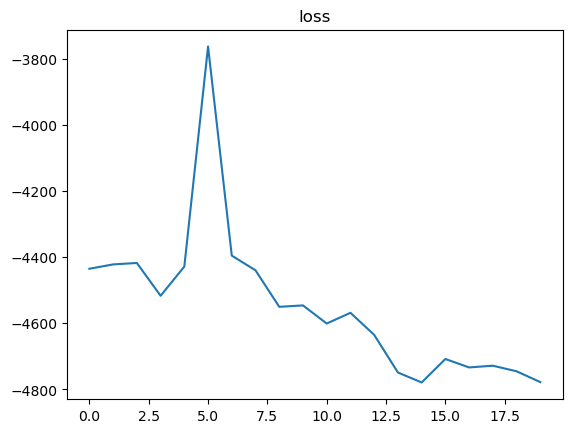

In [25]:
plt.plot(range(len(loss_vals)),loss_vals)
plt.title('loss')

Text(0.5, 1.0, 'loss')

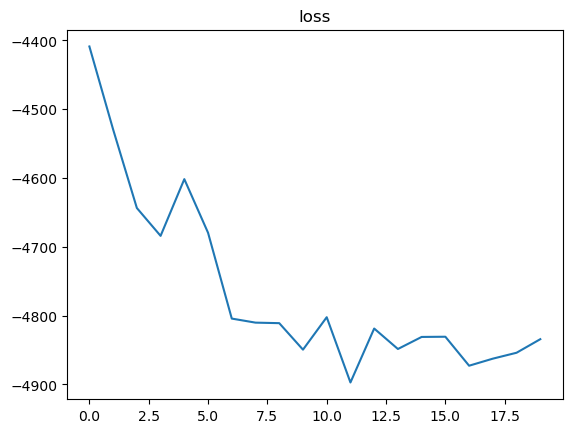

In [13]:
plt.plot(range(len(loss_vals)),loss_vals)
plt.title('loss')

In [26]:
def gen_im(model, im_size, nbh_size):
    m, n = nbh_size
    
    #new_im = np.zeros(im_size)
    #new_im = torch.zeros(im_size)
    #new_im = torch.full(im_size, 100.0)
    #new_im = torch.randint(low=50, high=150, size=im_size,dtype=torch.float)
    
    #new_im = torch.rand(im_size) # prøv med 0.5
    #new_im = torch.full(im_size,0.0)
    new_im = fashion_imgs[0][4]/255 -0.5
    
    pred_mu = np.ones(im_size)
    pred_sigma2 = np.ones(im_size)
    #neighborhood = train_img[i-m:i,j-n:j+n-1]
    #flat_n = neighborhood.flatten()
    
    
    for i in range(10, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i-m:i,j-n:(j+n+1)]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]
            #print(nbh_ij.shape)
            output = model(torch.reshape(nbh_ij,(1,17)))
            print(output.detach().numpy())
            #print(output)
            sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            
            
            pred_mu[i,j] = output.detach().numpy()[0,0]
            pred_sigma2[i,j] = np.abs(output.detach().numpy()[0,1])

            #new_im[i,j] = sample
    
    return new_im, pred_mu, pred_sigma2

In [27]:
generated_im, generated_mu, generated_sigma2 = gen_im(mlp, (28,28), (3,3))

[[-0.2930951   0.05446868]]
[[-0.12149179  0.0847234 ]]
[[0.19520727 0.08607613]]
[[0.17614943 0.08605942]]
[[0.27612758 0.11731283]]
[[0.22547936 0.12813348]]
[[0.20281515 0.12403972]]
[[0.18972033 0.11859522]]
[[0.21727926 0.12472225]]
[[0.19033217 0.11820865]]
[[0.21251094 0.12290551]]
[[0.19028994 0.11820524]]
[[0.19019163 0.11819727]]
[[0.24189192 0.13113794]]
[[0.19707143 0.11928431]]
[[0.24497384 0.12836859]]
[[0.27402025 0.13592483]]
[[0.27543604 0.13632506]]
[[0.69507694 0.1596865 ]]
[[0.2670856  0.13584399]]
[[0.3724777  0.14126132]]
[[0.25917995 0.18473886]]
[[-0.2930951   0.05446868]]
[[-0.01875895  0.09867881]]
[[0.17786464 0.08886233]]
[[0.2295754  0.09325889]]
[[0.20593578 0.12115418]]
[[0.25760144 0.13625832]]
[[0.16805914 0.11587529]]
[[0.18785793 0.11830691]]
[[0.18957502 0.11814743]]
[[0.2143842  0.12357941]]
[[0.21644485 0.12381472]]
[[0.23341125 0.1286481 ]]
[[0.23688787 0.12934777]]
[[0.20533958 0.12130714]]
[[0.19711283 0.11940131]]
[[0.26988262 0.13405603]]
[[0.

In [40]:
generated_im, generated_mu, generated_sigma2 = gen_im(mlp, (28,28), (3,3))

[[-1.0594907   0.06391471]]
[[-0.974247    0.08856349]]
[[-0.45379817  0.1183803 ]]
[[-0.58444345  0.08976006]]
[[-0.5966077   0.08966896]]
[[-0.53976166  0.10122089]]
[[-0.88244325  0.11869228]]
[[-0.60887873  0.10375631]]
[[-0.6256596   0.10008133]]
[[-0.58906174  0.10458893]]
[[-0.5947639   0.10412969]]
[[-0.57888204  0.10541378]]
[[-0.5736908   0.10583693]]
[[-0.74053204  0.10004998]]
[[-0.54551625  0.10808109]]
[[-0.48912138  0.11569883]]
[[-0.4776067   0.12121148]]
[[-0.47525388  0.1222548 ]]
[[-0.31710798  0.12768276]]
[[-0.46262372  0.11618135]]
[[-0.47783965  0.12451793]]
[[-0.85063106  0.14733353]]
[[-1.0596249  0.064144 ]]
[[-0.8057498   0.11248618]]
[[-0.597904    0.10084327]]
[[-0.5738015   0.09067807]]
[[-0.50372815  0.13615613]]
[[-0.539577    0.10446176]]
[[-0.5525541  0.1052652]]
[[-0.6157153   0.09885318]]
[[-0.5988031   0.10175823]]
[[-0.59405047  0.10418703]]
[[-0.58963645  0.10454255]]
[[-0.623508   0.0933951]]
[[-0.6071046   0.09838498]]
[[-0.56688166  0.10768034]

In [275]:
generated_im, generated_mu, generated_sigma2 = gen_im(mlp, (28,28), (3,3))

[[-0.18942222  0.13359065]]
[[-0.18942222  0.13359065]]
[[-0.18942222  0.13359065]]
[[-0.1782945   0.13417773]]
[[-0.17161244  0.13536263]]
[[-0.16373196  0.13483521]]
[[-0.15258697  0.1364903 ]]
[[-0.14966363  0.1416553 ]]
[[-0.16268441  0.13767888]]
[[-0.15422001  0.13978697]]
[[-0.1534063   0.14077456]]
[[-0.15913856  0.13712429]]
[[-0.15539072  0.13780165]]
[[-0.16510616  0.13663283]]
[[-0.15727407  0.13725258]]
[[-0.14941865  0.14087465]]
[[-0.16018118  0.13814318]]
[[-0.17087618  0.1363213 ]]
[[-0.17759885  0.13561708]]
[[-0.18733478  0.13357559]]
[[-0.18942222  0.13359065]]
[[-0.18942222  0.13359065]]
[[-0.18942222  0.13359065]]
[[-0.18937337  0.1335995 ]]
[[-0.18947715  0.13357393]]
[[-0.17946449  0.13504156]]
[[-0.17863575  0.13561435]]
[[-0.17693982  0.13616231]]
[[-0.15676482  0.13727829]]
[[-0.1540756   0.14056265]]
[[-0.17915088  0.1343389 ]]
[[-0.16251507  0.13813134]]
[[-0.17109725  0.13544872]]
[[-0.16695517  0.13433224]]
[[-0.16115013  0.13681804]]
[[-0.16874117  0.136

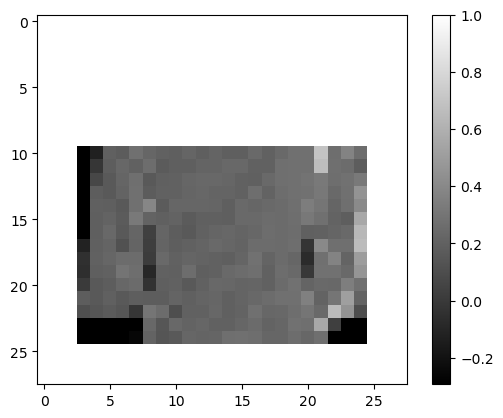

In [31]:
plt.imshow(generated_mu,cmap='gray')
plt.colorbar()

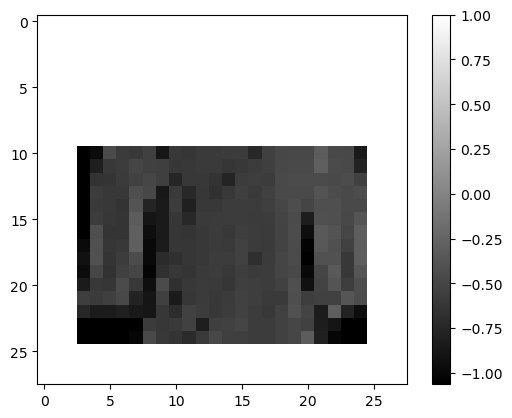

In [90]:
plt.imshow(generated_mu,cmap='gray')
plt.colorbar()

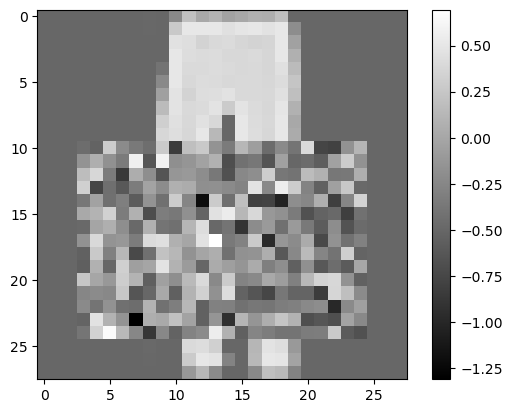

In [276]:
plt.imshow(generated_im,cmap='gray')
plt.colorbar()

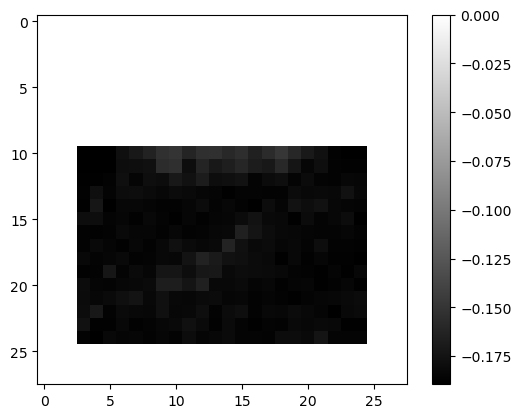

In [277]:
plt.imshow(generated_mu,cmap='gray')
plt.colorbar()

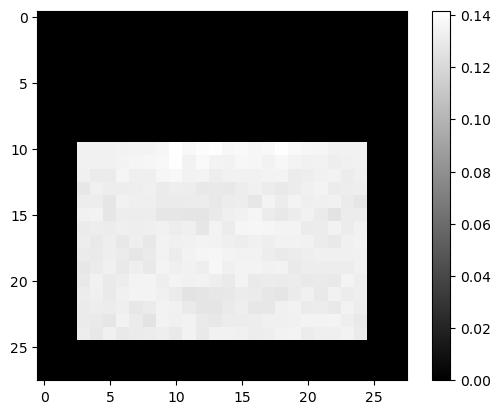

In [278]:
plt.imshow(generated_sigma2,cmap='gray')
plt.colorbar()

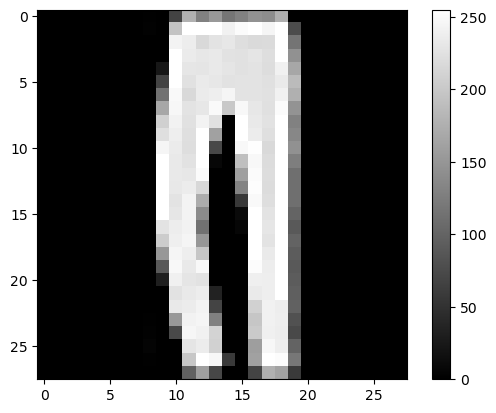

In [47]:
plt.imshow(fashion_imgs[0][2],cmap='gray')
plt.colorbar()

In [67]:
mlp(torch.rand((1,17)))

tensor([[-0.2095,  0.1394]], grad_fn=<CatBackward>)

In [38]:
#plt.imshow(np.clip(generated_im, 0, 1),cmap='gray')
#plt.colorbar()

In [37]:
class MLP_Mix(nn.Module):#define neighborhood size
    '''
    Multilayer Perceptron.
    '''
    def __init__(self, first_layer_size, num_mixtures):
        super().__init__()
        self.first_layer_size = first_layer_size
        self.num_mixtures = num_mixtures
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.first_layer_size, 34),
        nn.ReLU(),
        nn.Linear(34, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(), ## leaky relu
        nn.Linear(64, 3*self.num_mixtures),#,
        #nn.ReLU()
        #nn.Sigmoid()
        
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        '''Forward pass'''
        out = self.layers(x)
        #print(out.shape)
        softplus = nn.Softplus()
        #mu = torch.reshape(out[:,0:self.num_mixtures],(out.shape[0],1))
        #sig = torch.reshape(torch.exp(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],1))
        #pi_mix = torch.reshape(out[:,2*self.num_mixtures:3*self.num_mixtures],(out.shape[0],1))
        mu = torch.reshape(out[:,0:self.num_mixtures],(out.shape[0],self.num_mixtures))
        #mu1 = softplus(mu[:,0])
        #mu2 = -softplus(mu[:,1])
        #mu = torch.cat((mu1,mu2), dim=1)
        #sig = torch.reshape(torch.exp(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],self.num_mixtures))
        sig = torch.reshape(softplus(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],self.num_mixtures))
        pi_mix = torch.reshape(out[:,2*self.num_mixtures:3*self.num_mixtures],(out.shape[0],self.num_mixtures))

        pi_mix = self.softmax(pi_mix)

        out = torch.cat((mu,sig,pi_mix),dim=1)
        #print(out)
        return out

In [81]:
def Mixture_Gauss_NLLLoss(target, mu, sigma, pi_mix):
    total_lik = 0
    loss_func  = nn.GaussianNLLLoss(full=False, reduction='none')
    sigma = torch.clamp(sigma, 0.0000001)
    for i in range(mu.shape[1]):


        #print(pi_mix[:,i].shape)
        #print(loss_func(mu[:,i], target, sigma[:,i]).shape)
        #loss_i = -(torch.log(pi_mix[:,i]))+loss_func(mu[:,i], target, sigma[:,i])  #nn.GaussianNLLLoss(mu[i], target, sigma[i])
        loss = loss_func(mu[:,i], target, sigma[:,i])
        likelihood = torch.exp(-loss)
        #print(likelihood.shape)
        #print(mu.shape)
        total_lik += pi_mix[:,i]*likelihood #sum , mean????

    #print(total_lik.shape)
    gauss_mix_loss = torch.log(total_lik)
    #print(torchgauss_mix_loss)
    #print(total_loss.shape)
    return -gauss_mix_loss.mean()  #torchmean

In [108]:
for i in range(1):
    print(i)

0


In [117]:
nn.GaussianNLLLoss(full=True, reduction='mean')(torch.ones((50,1)), torch.ones((50,1)), torch.ones((50,1)))

tensor(0.9189)

In [186]:
Mixture_Gauss_NLLLoss(torch.ones((50,1)), torch.ones((50,2)), torch.ones((50,2)),torch.ones((50,2)))

tensor(-0.6931)

In [98]:
import torch.distributions

In [10]:
def norm_pdf(mu, sig2, y):
    #return 1/(torch.sqrt(2*3.14*sig2))*torch.exp(-(y-mu)**2/2*sig2)
    return (1/(torch.sqrt(sig2)))*torch.exp(-((y-mu)**2)/(2*sig2))

In [63]:
def ngmm_ll(y, mu, sig2, pi_mix):
    loss = 0
    sig2 = torch.clamp(sig2, min=0.00000001)
    for i in range(pi_mix.shape[1]):
        likelihood = pi_mix[:,i]*norm_pdf(mu[:,i], sig2[:,i], y)
        loss += likelihood

    log_likelihood = torch.log(loss)

    return -log_likelihood.mean()

In [64]:
ngmm_ll(torch.ones((50,1)), torch.ones((50,2)), torch.ones((50,2)), torch.ones((50,2)))

tensor(-0.6931)

In [120]:
#norm_pdf(torch.ones((50,1)), torch.ones((50,1)), torch.ones((50,1)))

In [121]:
#aa = torch.distributions.Normal(torch.zeros((50,1)), torch.ones((50,1)))
#aa.pdf(torch.ones((50,1)))

In [127]:
dataloader = DataLoader(fashion, batch_size=20,
                        shuffle=True)#, num_workers=0)

In [179]:
### preøv med annen batch size, og at mu1 og mu2 skal være forskjellig
### finne ut hvorfor det blir NANs

In [128]:
mlp_mix = MLP_Mix(first_layer_size=17, num_mixtures=2)

# Define the loss function and optimizer
#loss_function = nn.GaussianNLLLoss(full=False, reduction='mean')
loss_function  = Mixture_Gauss_NLLLoss
#loss_function  = ngmm_ll

optimizer = torch.optim.SGD(mlp_mix.parameters(), lr=0.01)

In [129]:
epochs = 5 #20
loss_vals = []
#torch.autograd.detect_anomaly()

In [130]:
for e in range(epochs): # 5 epochs at maximum
    #torch.autograd.detect_anomaly()
    # Print epoch
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    for i, data in enumerate(dataloader, 0):
        #torch.autograd.detect_anomaly(True)
        #current_loss = 0.0
      # Get and prepare inputs
        data = torch.reshape(data,(-1,18))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp_mix(inputs)

        #pi_mix = outputs[:,6:].reshape((targets.shape[0], -1))
        #mu_s = outputs[:,0:3].reshape((targets.shape[0], -1))
        #sigma_s = outputs[:,3:6].reshape((targets.shape[0], -1))
        #pi_mix = outputs[:,2].reshape((targets.shape[0], -1))
        #mu_s = outputs[:,0].reshape((targets.shape[0], -1))
        #sigma_s = outputs[:,1].reshape((targets.shape[0], -1))
        mu_s = outputs[:,0:2]
        sigma_s = outputs[:,2:4]  #sigma2 
        pi_mix = outputs[:,4:6]
        #sigma_s = torch.exp(outputs[:,1])
        #print(outputs.shape)
        #print(mu_s.shape)
      # Compute loss
        #loss = loss_function(outputs, targets)
        loss = loss_function(targets, mu_s, sigma_s, pi_mix)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        
        #if i % 500 == 0:
        #if i % 20 == 0:
    
    print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / len(dataloader)))
    #current_loss = 0.0

  # Process is complete.
    loss_vals.append(current_loss)
    print('Training process has finished.')

Starting epoch 1
Loss after mini-batch  3000: -1.290
Training process has finished.
Starting epoch 2
Loss after mini-batch  3000: -1.683
Training process has finished.
Starting epoch 3
Loss after mini-batch  3000: -1.761
Training process has finished.
Starting epoch 4
Loss after mini-batch  3000: -1.800
Training process has finished.
Starting epoch 5
Loss after mini-batch  3000: -1.871
Training process has finished.


Text(0.5, 1.0, 'loss')

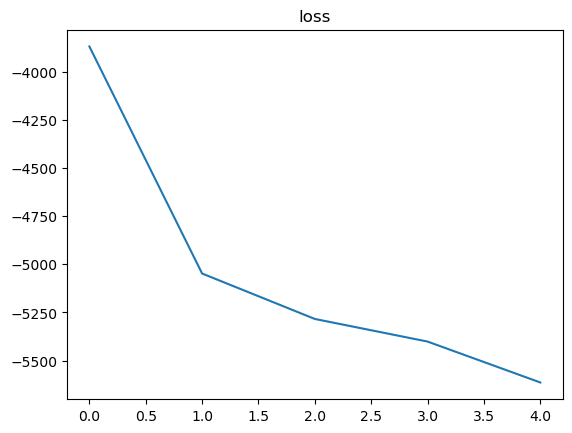

In [131]:
plt.plot(range(len(loss_vals)),loss_vals)
plt.title('loss')

Text(0.5, 1.0, 'loss')

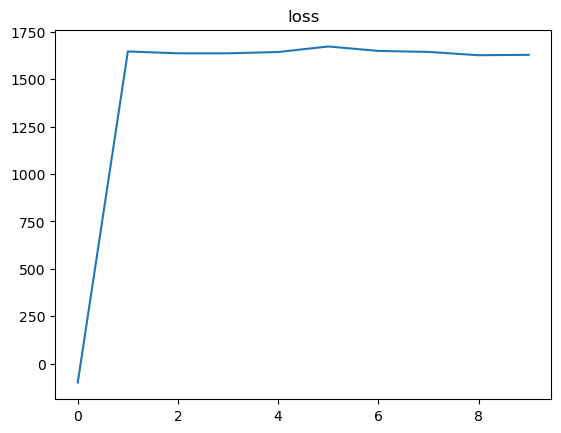

In [136]:
plt.plot(range(len(loss_vals)),loss_vals)
plt.title('loss')

In [183]:
def gen_im_mix(model, im_size, nbh_size):
    m, n = nbh_size
    
    #new_im = np.zeros(im_size)
    #new_im = torch.zeros(im_size)
    #new_im = torch.full(im_size, 100.0)
    #new_im = torch.randint(low=50, high=150, size=im_size,dtype=torch.float)
    
    #new_im = torch.rand(im_size)-0.5 # prøv med 0.5
    #new_im = torch.full(im_size,0.5)
    pred_mu = np.ones(im_size)
    pred_sigma2 = np.ones(im_size)
    pred_mu2 = np.ones(im_size)
    pred_sigma2_2 = np.ones(im_size)
    pred_pi_mix = np.ones(im_size)
    #neighborhood = train_img[i-m:i,j-n:j+n-1]
    #flat_n = neighborhood.flatten()
    new_im = fashion_imgs[0][2]/255 - 0.5
    
    for i in range(10, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i-m:i,j-n:(j+n+1)]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]
            
            #print(nbh_ij.shape)
            output = model(torch.reshape(nbh_ij,(1,17))).detach().numpy()

            #pi_mix_output = output[0,2]
            #mu_output = output[0,0]
            #sigma2_output = output[0,1]
            #print(sigma2_output)
            pi_mix_output = output[0,4:]
            mu_output = output[0,0:2]
            sigma2_output = output[0,2:4]
            print(pi_mix_output)
            
            pi_mix_sample = np.random.choice(2, 1, p=pi_mix_output)[0]
            #pi_mix_sample = 0
            print(mu_output)
            #print(sigma2_output)
            #print(pi_mix_output)
            #sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            sample = np.random.normal(mu_output[pi_mix_sample], np.sqrt(sigma2_output[pi_mix_sample]))
            #sample = np.random.normal(mu_output, np.sqrt(sigma2_output))
            
            new_im[i,j] = sample

            #pred_mu[i,j] = mu_output[pi_mix_sample]
            #pred_sigma2[i,j] = sigma2_output[pi_mix_sample]
            pred_mu[i,j] = mu_output[0]
            pred_sigma2[i,j] = sigma2_output[0]

            pred_mu2[i,j] = mu_output[1]
            pred_sigma2_2[i,j] = sigma2_output[1]
            pred_pi_mix[i,j] = pi_mix_output[0]
    
    #return new_im, pred_mu, pred_sigma2
    return new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix

In [184]:
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix(mlp_mix, (28,28), (3,3))

[0.865778   0.13422197]
[-0.533609   -0.51373214]
[0.865778   0.13422197]
[-0.533609   -0.51373214]
[0.865778   0.13422197]
[-0.533609   -0.51373214]
[0.86359334 0.1364067 ]
[-0.5340289  -0.49977177]
[0.865701   0.13429905]
[-0.5344547  -0.49174562]
[0.79156804 0.20843199]
[-0.5284559  -0.29205242]
[0.32966307 0.6703369 ]
[0.29159266 0.30638567]
[0.3120689 0.6879311]
[0.3672436  0.44210514]
[0.34849685 0.6515031 ]
[0.30522585 0.35955647]
[0.31262326 0.6873768 ]
[0.35693806 0.39673063]
[0.29008996 0.70991004]
[0.38124704 0.37803248]
[0.80180454 0.19819549]
[-0.52353984 -0.20101678]
[0.2813423 0.7186577]
[0.40903264 0.3976114 ]
[0.29853448 0.70146555]
[0.38178396 0.42217633]
[0.33284235 0.66715765]
[0.31717777 0.34793046]
[0.27850428 0.7214957 ]
[0.41891837 0.4250932 ]
[0.45724228 0.54275775]
[-0.11832911  0.1317105 ]
[0.84562904 0.15437101]
[-0.5325485  -0.38506335]
[0.8781984  0.12180162]
[-0.5353223  -0.53811157]
[0.8663489  0.13365108]
[-0.53448695 -0.5200963 ]
[0.865778   0.13422197

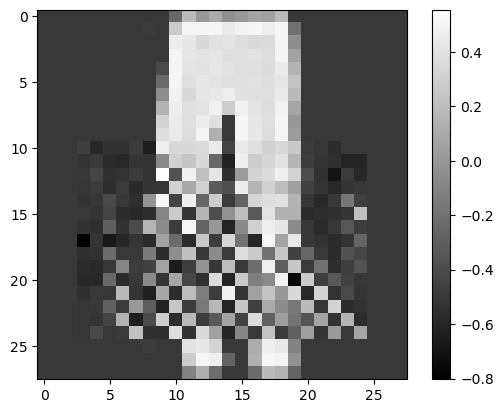

In [185]:
plt.imshow(new_im,cmap='gray')
plt.colorbar()

In [188]:
#plt.imshow(fashion_imgs[0][2],cmap='gray')
#plt.colorbar()

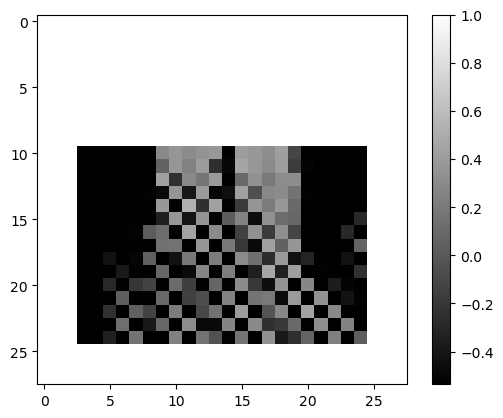

In [189]:
plt.imshow(pred_mu,cmap='gray')
plt.colorbar()

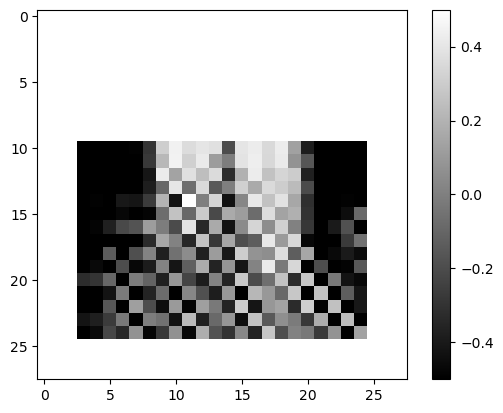

In [190]:
plt.imshow(pred_mu2,cmap='gray', vmax=0.5, vmin=-0.5)
plt.colorbar()

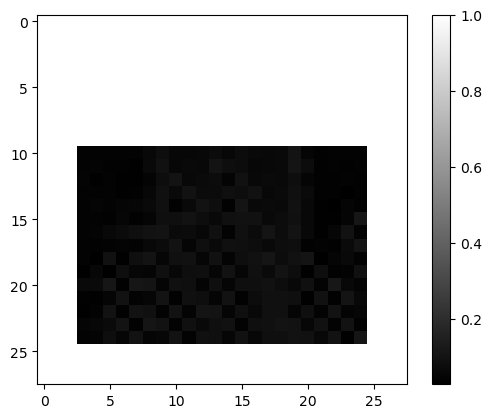

In [192]:
plt.imshow(np.sqrt(pred_sigma2),cmap='gray')#, vmax=0.2)
plt.colorbar()

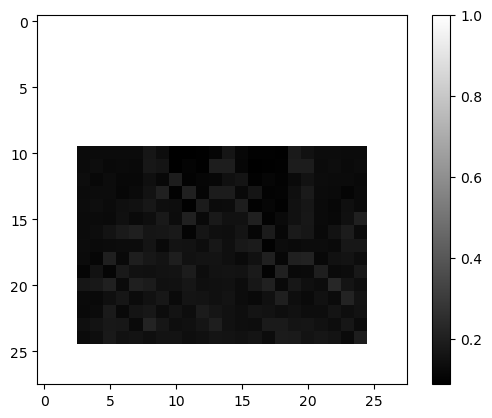

In [193]:
plt.imshow(np.sqrt(pred_sigma2_2),cmap='gray')
plt.colorbar()

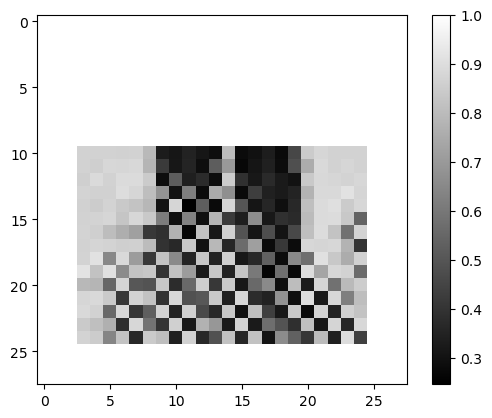

In [194]:
plt.imshow(pred_pi_mix,cmap='gray')
plt.colorbar()

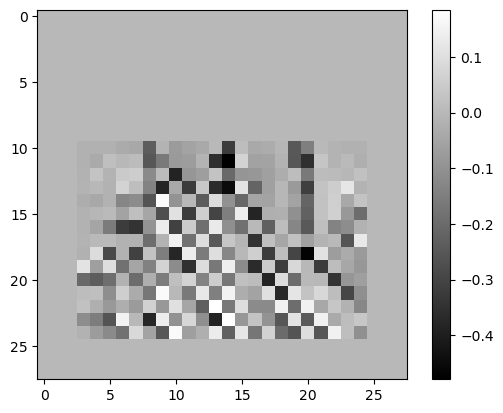

In [195]:
plt.imshow(pred_mu-pred_mu2,cmap='gray')
plt.colorbar()

In [139]:
generated_im_mix, gen_mu, gen_sigma2 = gen_im_mix(mlp_mix, (28,28), (3,3))

[0.865778   0.13422197]
[-0.533609   -0.51373214]
[0.865778   0.13422197]
[-0.533609   -0.51373214]
[0.865778   0.13422197]
[-0.533609   -0.51373214]
[0.86359334 0.1364067 ]
[-0.5340289  -0.49977177]
[0.865701   0.13429905]
[-0.5344547  -0.49174562]
[0.79156804 0.20843199]
[-0.5284559  -0.29205242]
[0.32966307 0.6703369 ]
[0.29159266 0.30638567]
[0.3120689 0.6879311]
[0.3672436  0.44210514]
[0.34849685 0.6515031 ]
[0.30522585 0.35955647]
[0.31262326 0.6873768 ]
[0.35693806 0.39673063]
[0.29008996 0.70991004]
[0.38124704 0.37803248]
[0.80180454 0.19819549]
[-0.52353984 -0.20101678]
[0.2813423 0.7186577]
[0.40903264 0.3976114 ]
[0.29853448 0.70146555]
[0.38178396 0.42217633]
[0.33284235 0.66715765]
[0.31717777 0.34793046]
[0.27850428 0.7214957 ]
[0.41891837 0.4250932 ]
[0.45724228 0.54275775]
[-0.11832911  0.1317105 ]
[0.84562904 0.15437101]
[-0.5325485  -0.38506335]
[0.8781984  0.12180162]
[-0.5353223  -0.53811157]
[0.8663489  0.13365108]
[-0.53448695 -0.5200963 ]
[0.865778   0.13422197

In [132]:
generated_im_mix, gen_mu, gen_sigma2 = gen_im_mix(mlp_mix, (28,28), (3,3))

[-0.6480908 -0.5450534]
[-0.6480908 -0.5450534]
[-0.6480908 -0.5450534]
[-0.61231625 -0.5228613 ]
[-0.5745612 -0.5203077]
[-0.545208   -0.48228353]
[-0.5648202  -0.53403854]
[-0.5634307 -0.5262224]
[-0.5831064  -0.49898008]
[-0.5177635  -0.40622887]
[-0.48342133 -0.38963693]
[-0.5117833 -0.3925069]
[-0.510098   -0.43942955]
[-0.5030008 -0.4401151]
[-0.5555527  -0.44325647]
[-0.49218872 -0.39159042]
[-0.5164733  -0.40671772]
[-0.5310275 -0.3978951]
[-0.5556461  -0.41800827]
[-0.61117953 -0.4880237 ]
[-0.6480908 -0.5450534]
[-0.6480908 -0.5450534]
[-0.6480908 -0.5450534]
[-0.65137786 -0.54872304]
[-0.65243816 -0.5497013 ]
[-0.6174995 -0.5327404]
[-0.57676464 -0.52772325]
[-0.5498976 -0.4881482]
[-0.5701512  -0.54331696]
[-0.60687083 -0.5822671 ]
[-0.6313107  -0.56109196]
[-0.5763446 -0.5357258]
[-0.5593195 -0.5306496]
[-0.5418817  -0.44736022]
[-0.527042  -0.5015942]
[-0.5819096 -0.5437779]
[-0.6198732  -0.53991723]
[-0.6333141 -0.5496786]
[-0.6478775 -0.5472163]
[-0.6206452 -0.5113666]


In [61]:
generated_im_mix, gen_mu, gen_sigma2 = gen_im_mix(mlp_mix, (28,28), (3,3))

-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.44048667
0.28952843
0.4019996
0.3692093
0.32314867
0.318106
-0.31857693
0.42551154
0.32165277
0.34637326
0.33739895
-0.017555028
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.24331136
-0.44048667
-0.44048667
-0.20356776
-0.44048667
-0.44048667
0.43881464
0.3698743
0.31765538
0.14417791
-0.44048667
0.44345534
0.12854123
0.37067336
0.3217125
0.060352147
-0.21495178
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.2537229
-0.44048667
-0.44048667
-0.116237134
-0.44048667
-0.31133914
0.29208797
0.12882096
0.4111172
0.36298913
-0.11279604
-0.07332033
-0.15448025
0.25534135
0.40603483
0.027356654
0.34790874
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.44048667
-0.2220299
-0.053315252
-0.44048667
0.1083743
-0.44048667
-0.13926363
0.24126673
0.40966606
0.25727767
-0.09386161
-0.24024878
0.4023062
-0.0010201037
-0.090643466
0.6068295
-0.47903717
0.17785698
-0.44048667
0.06308985
-0.440

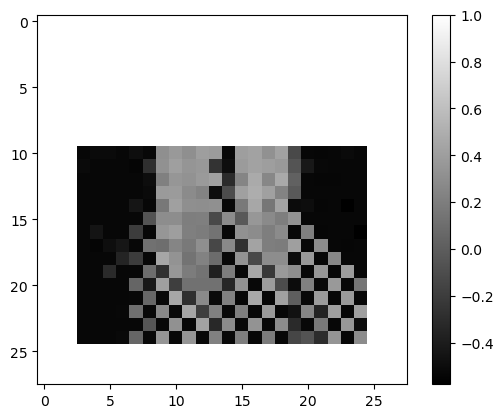

In [141]:
plt.imshow(gen_mu,cmap='gray')
plt.colorbar()

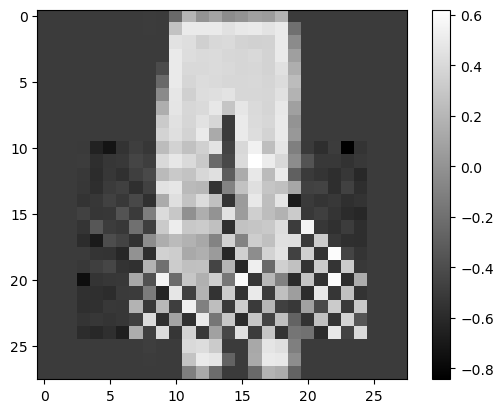

In [142]:
plt.imshow(generated_im_mix,cmap='gray')
plt.colorbar()

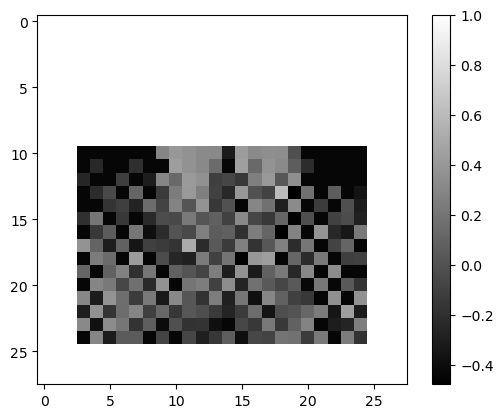

In [62]:
plt.imshow(gen_mu,cmap='gray')
plt.colorbar()

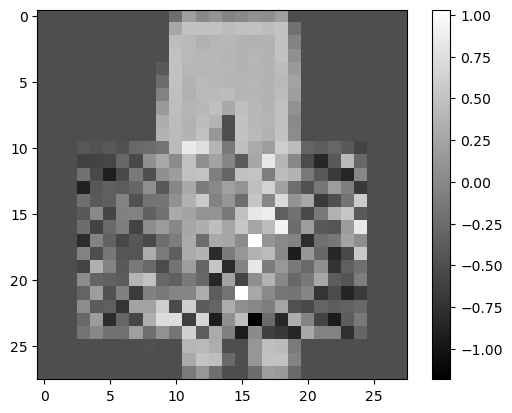

In [51]:
plt.imshow(generated_im_mix,cmap='gray')
plt.colorbar()

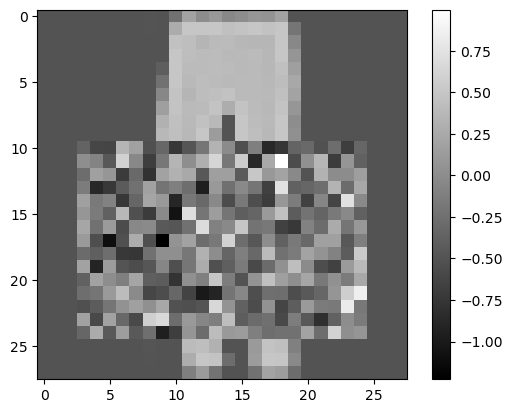

In [73]:
plt.imshow(generated_im_mix,cmap='gray')
plt.colorbar()

In [210]:
generated_im_mix = gen_im_mix(mlp_mix, (100,100), (3,3))

[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.03425117 0.37787843]
[0.80134726 0.034251

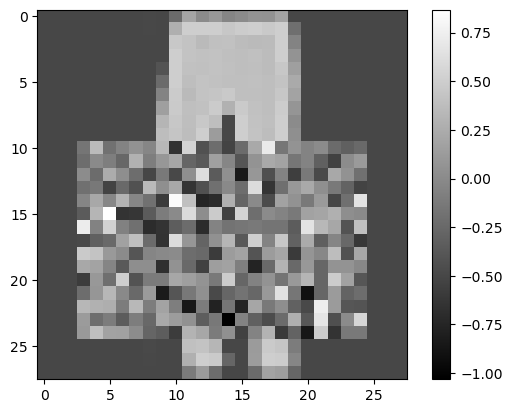

In [149]:
plt.imshow(generated_im_mix,cmap='gray')
plt.colorbar()

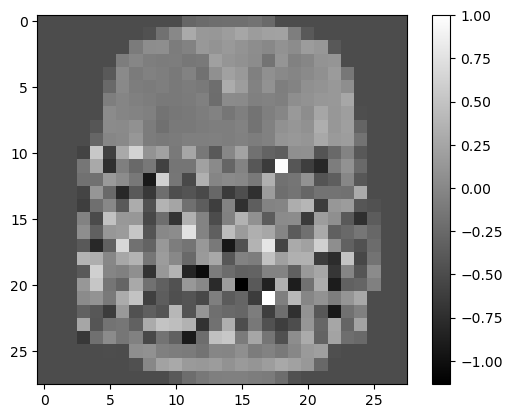

In [87]:
plt.imshow(generated_im_mix,cmap='gray')
plt.colorbar()

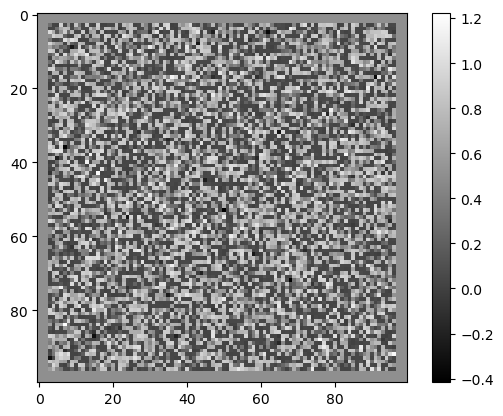

In [211]:
plt.imshow(generated_im_mix,cmap='gray')
plt.colorbar()

In [215]:
#### train on larger mini batch
#### test different learning rate
#### start with images and generate
#### skrive om NN, skrive om loss for andre foredlingfer og ta med modell og prarametre i likning